### Visualization/Stats for the belief state space
For thinking about how to partition this space, what are some visualizations that could help us? Do this with Blanche and Sam
- Plots of belief distributions by features. might help determine what are good cutoffs for partitioning
- plots of value distribution
- plots of value correlation with belief entropy

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.io_utils as io_utils
import os
from distutils.util import strtobool

import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from constants.behavioral_constants import *


### Load Data

In [8]:
sub = "SA"
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"
valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
beh = pd.concat(valid_sess.apply(lambda x: behavioral_utils.get_valid_belief_beh_for_sub_sess(sub, x.session_name), axis=1).values)

### Look at belief distributions by feature: 
Edgar: Should also just plot this in just square blocks

See they're kind of bimodal-ish, with a dip at b(z) = 0.3

#### First for one example feat: 

Text(0.5, 1.0, 'On trials where feat was chosen')

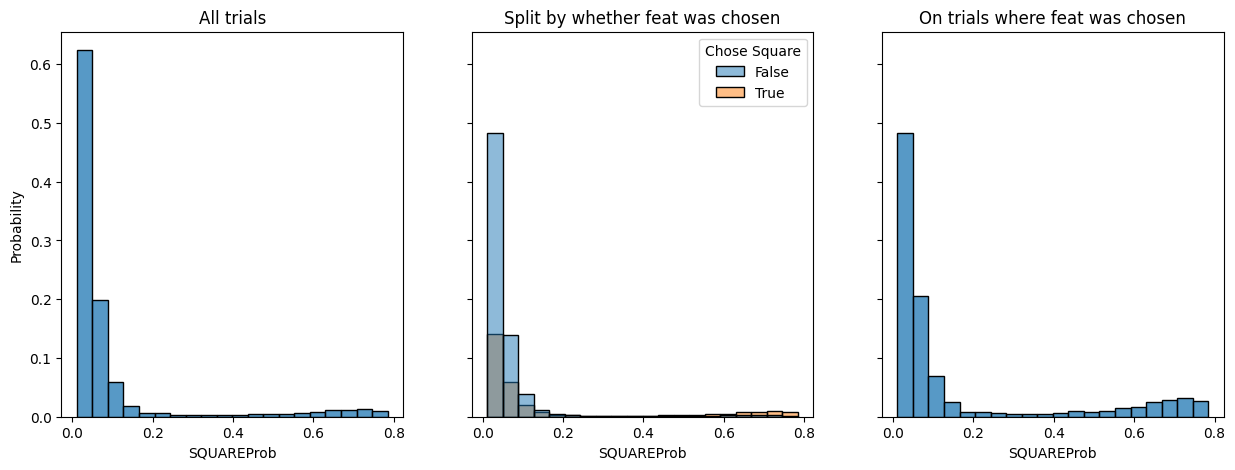

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# beh = beh[beh.CurrentRule == "SQUARE"]

sns.histplot(beh, x="SQUAREProb", stat="probability", bins=20, ax=ax1)
ax1.set_title("All trials")

beh["Chose Square"] = beh.Shape == "SQUARE"
sns.histplot(beh, x="SQUAREProb", stat="probability", hue="Chose Square", bins=20, ax=ax2)
ax2.set_title("Split by whether feat was chosen")

sub_beh = beh[beh["Chose Square"]]
sns.histplot(sub_beh, x="SQUAREProb", stat="probability", bins=20, ax=ax3)
ax3.set_title("On trials where feat was chosen")



#### Now look at all features

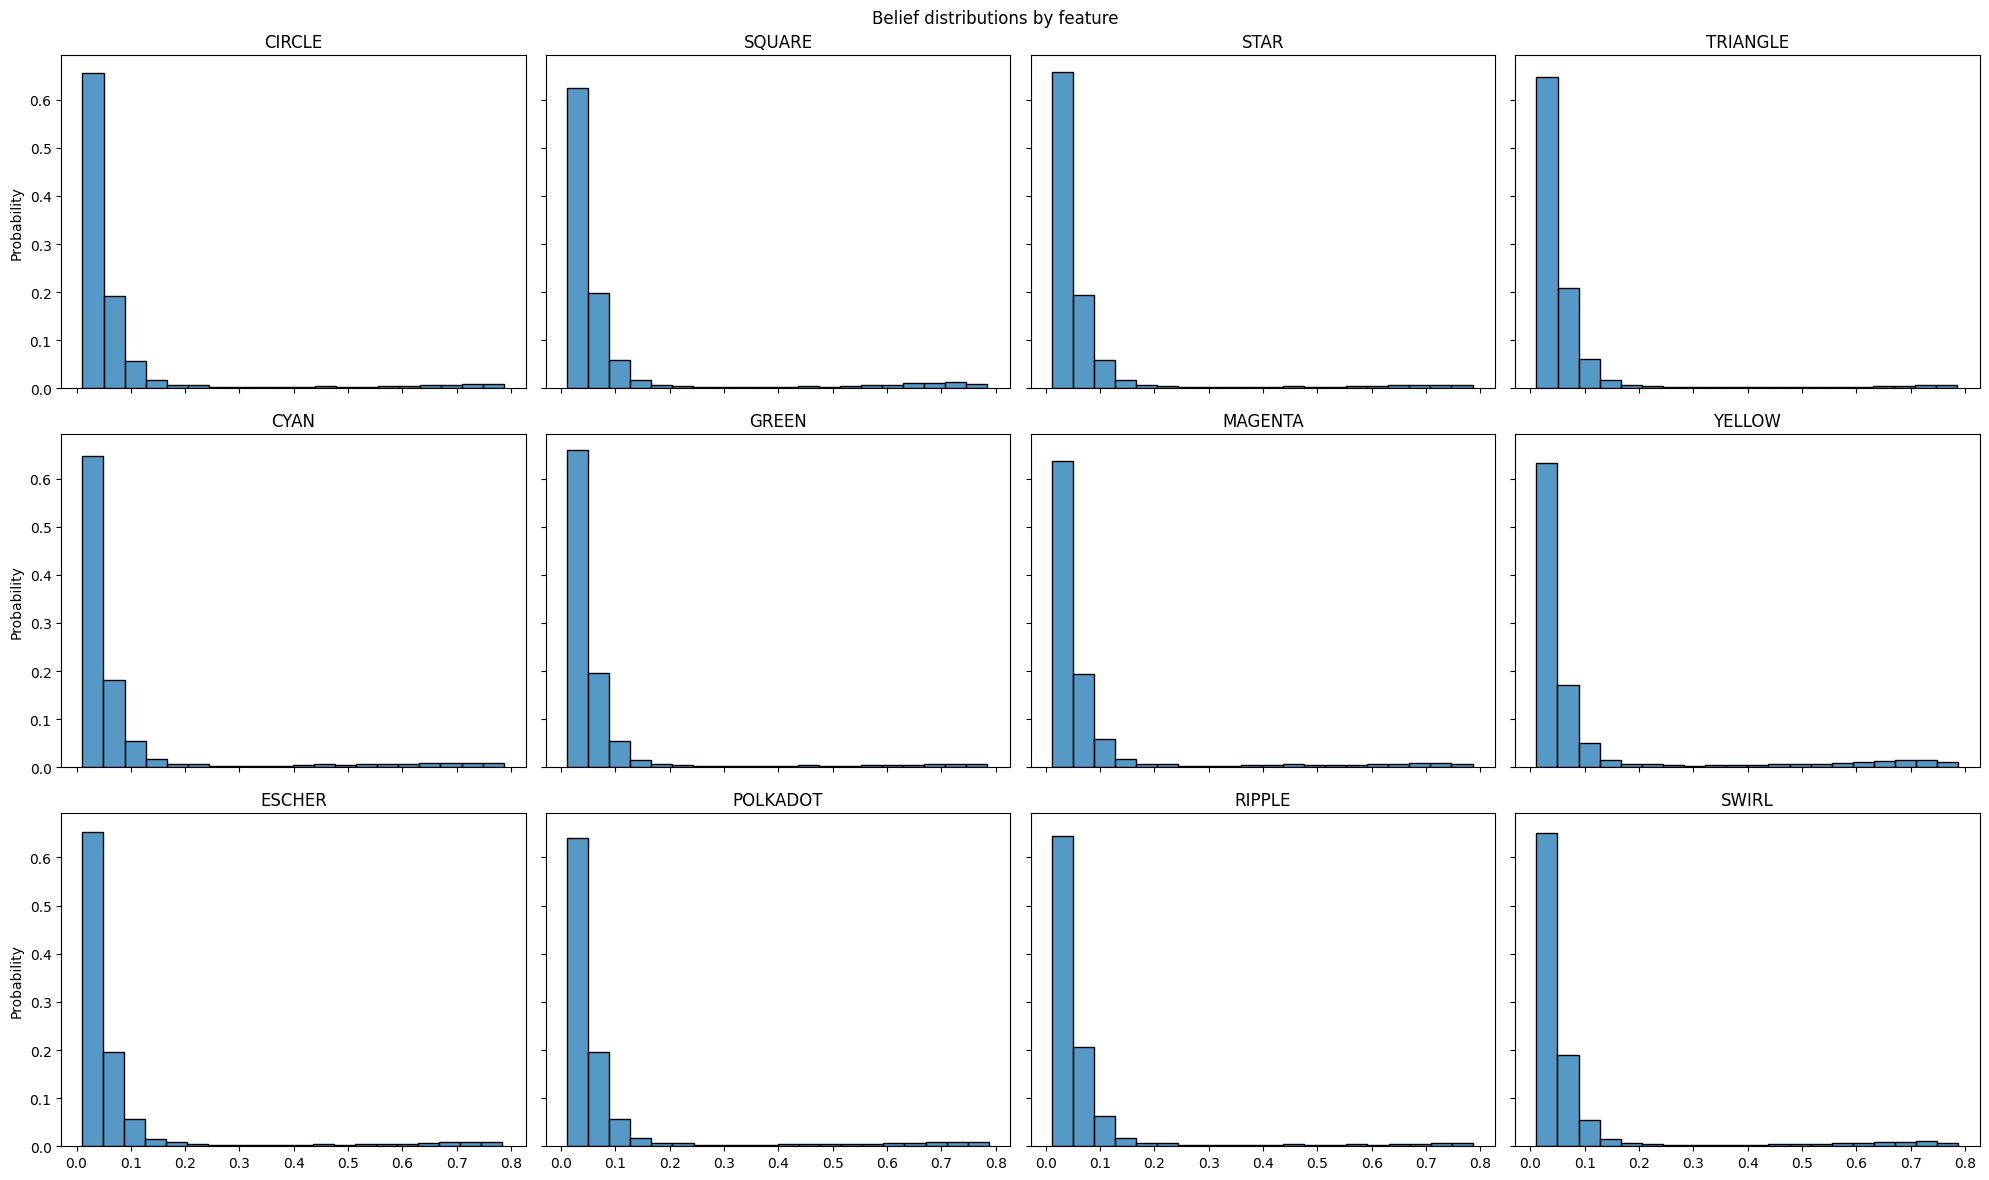

In [4]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)
for i, feat in enumerate(FEATURES): 
    ax = axs[i // 4, i % 4]    
    sns.histplot(beh, x=f"{feat}Prob", stat="probability", bins=20, ax=ax)
    ax.set_title(f"{feat}")
    ax.set_xlabel("")
fig.suptitle("Belief distributions by feature")
fig.tight_layout()


### What is the distribution of belief state values?
How does it split by belief state value bins? Computed median for each session

<Axes: xlabel='BeliefStateValue', ylabel='Probability'>

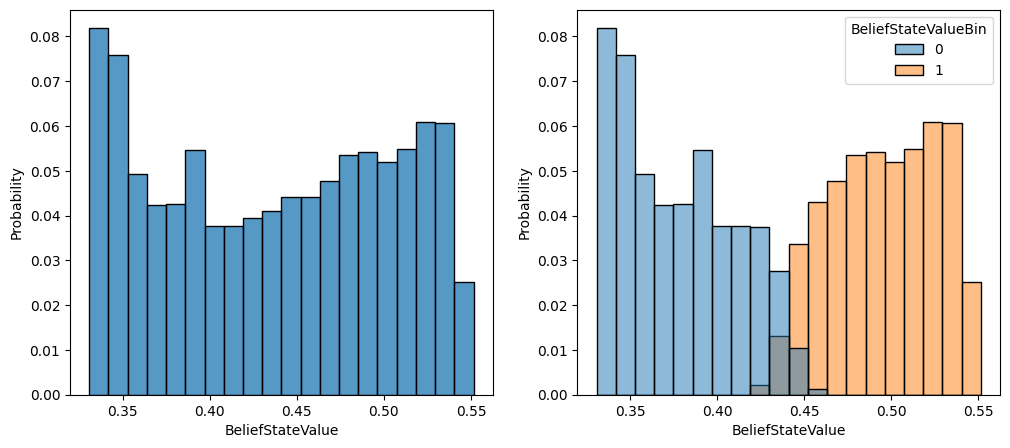

In [10]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 5))
sns.histplot(beh, x="BeliefStateValue", stat="probability", bins=20, ax=axs[0])
sns.histplot(beh, x="BeliefStateValue", hue="BeliefStateValueBin", stat="probability", bins=20, ax=axs[1])

### What do low val vs. high preferring X look like in terms of belief distributions?
Low vs. high determined by median of belief state value

<Axes: xlabel='CIRCLEProb', ylabel='Probability'>

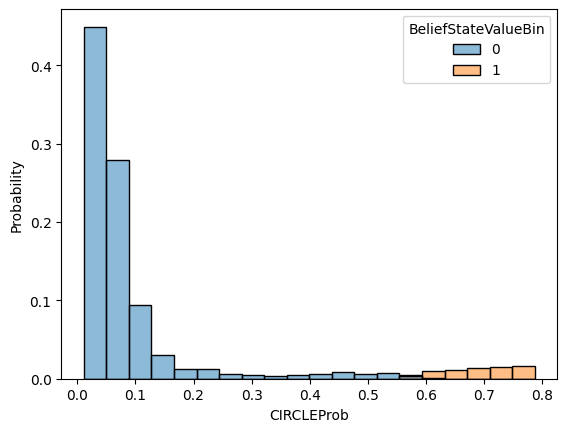

In [6]:
feat = "CIRCLE"
sub_beh = beh[beh.BeliefStateValueLabel.isin(["Low", f"High {feat}"])]    
sns.histplot(sub_beh, x=f"{feat}Prob", hue="BeliefStateValueBin", stat="probability", bins=20)

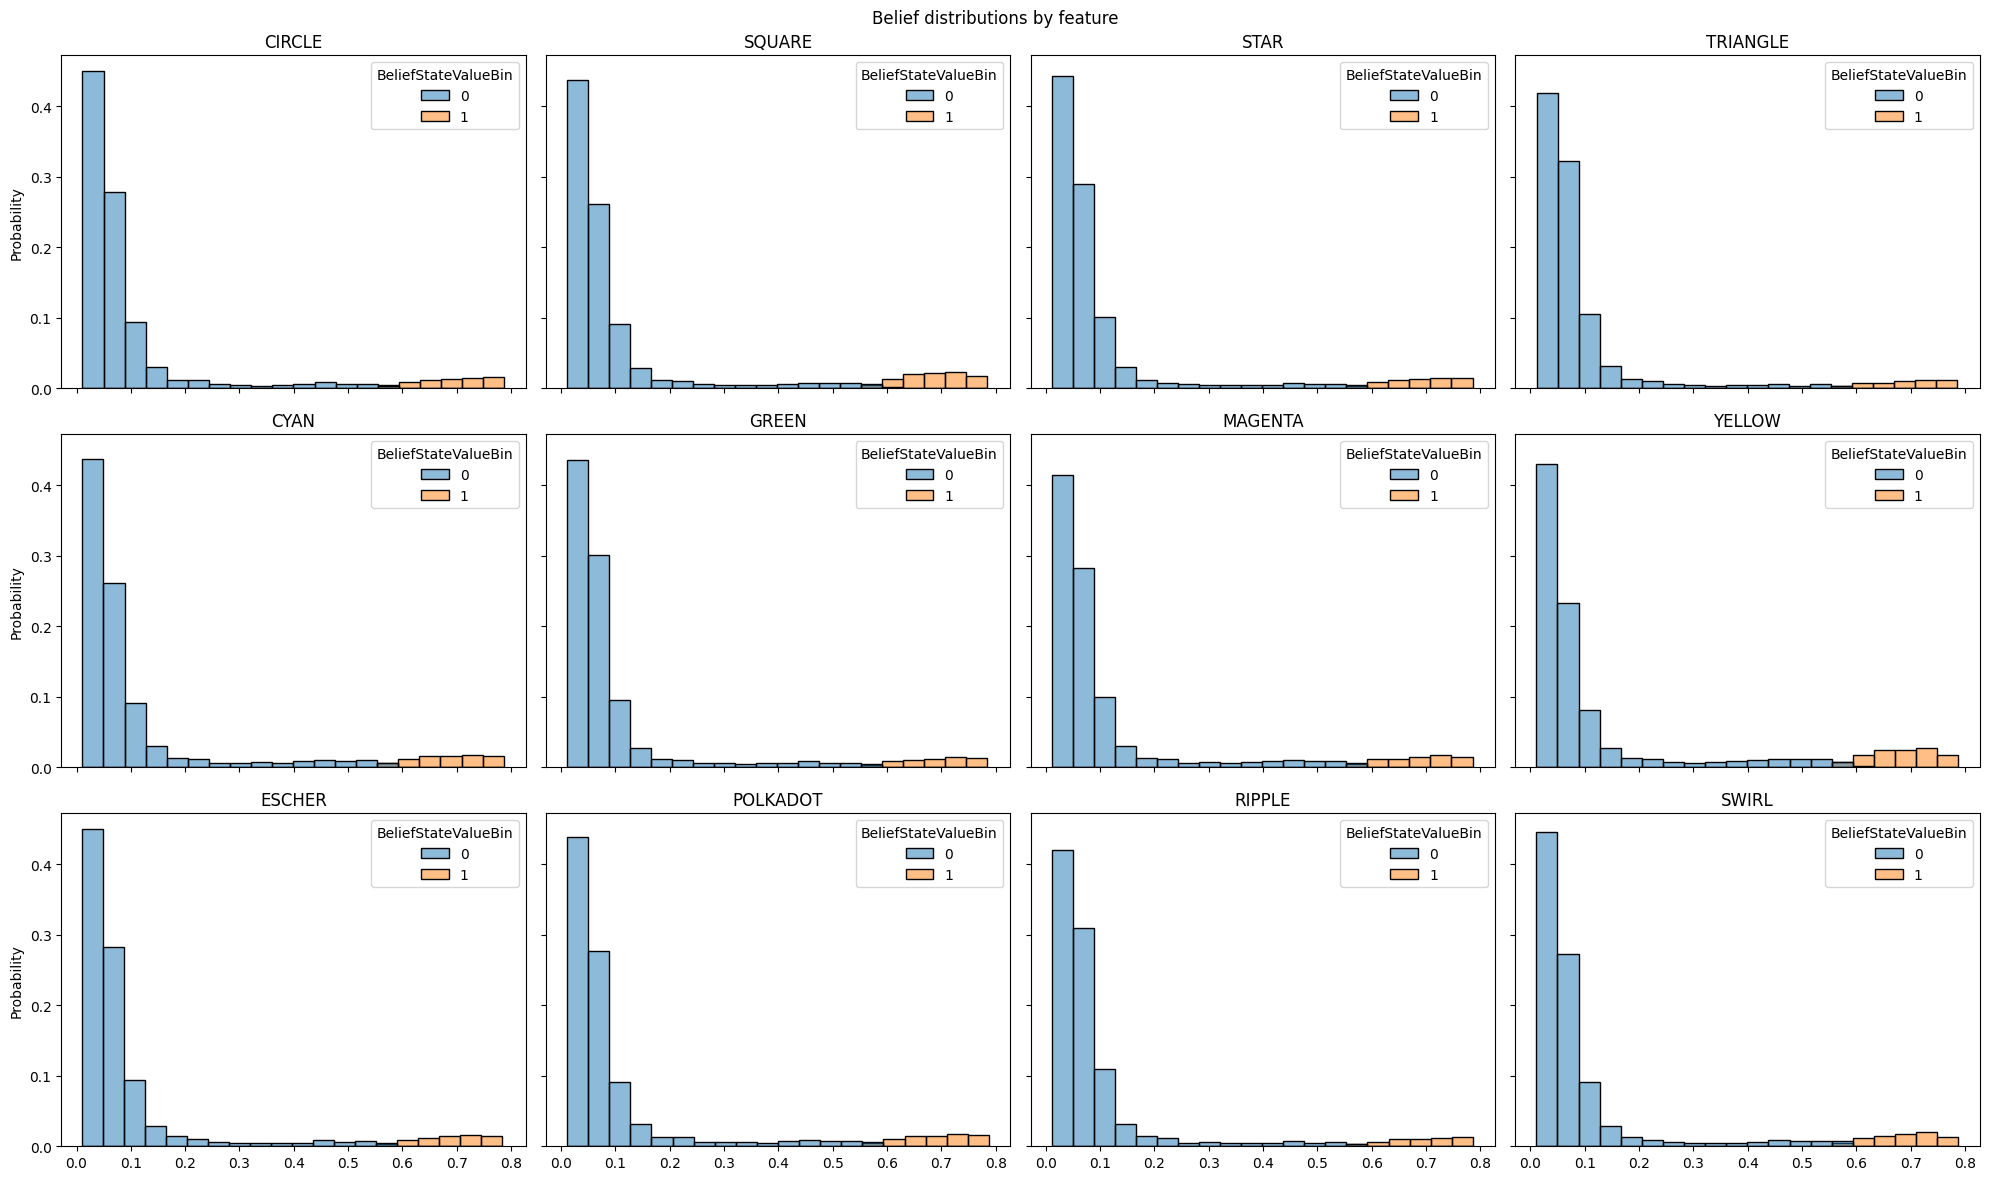

In [7]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)
for i, feat in enumerate(FEATURES): 
    ax = axs[i // 4, i % 4]
    sub_beh = beh[beh.BeliefStateValueLabel.isin(["Low", f"High {feat}"])]    
    sns.histplot(sub_beh, x=f"{feat}Prob", hue="BeliefStateValueBin", stat="probability", bins=20, ax=ax)
    ax.set_title(f"{feat}")
    ax.set_xlabel("")
fig.suptitle("Belief distributions by feature")
fig.tight_layout()

### What is the relationship between belief state entropy, belief state value, preferred belief probability?

In [8]:
probs = beh[[f"{feat}Prob" for feat in FEATURES]].values
beh["Entropy"] = -1 * np.sum(probs * np.log(probs), axis=1)

<Axes: xlabel='Entropy', ylabel='PreferredBeliefProb'>

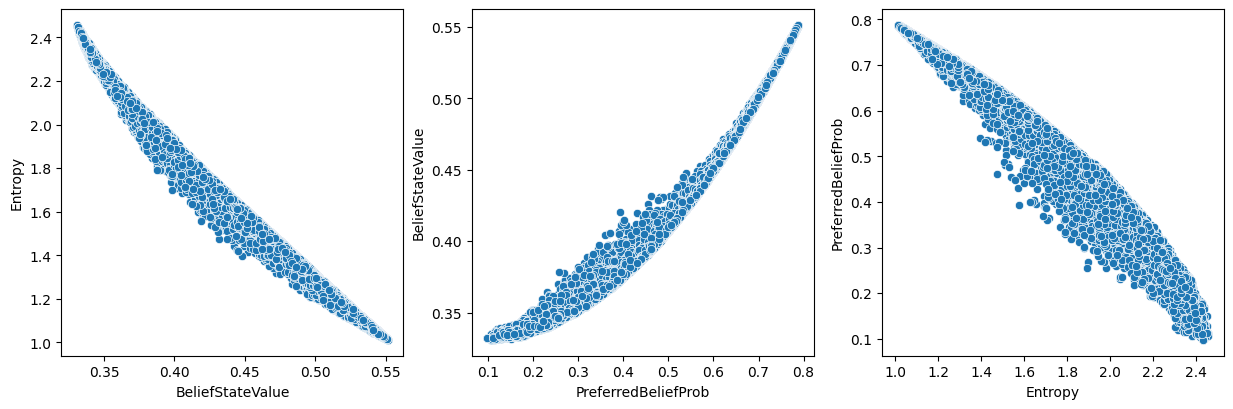

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
sns.scatterplot(beh, x="BeliefStateValue", y="Entropy", ax=ax1)
sns.scatterplot(beh, x="PreferredBeliefProb", y="BeliefStateValue", ax=ax2)
sns.scatterplot(beh, x="Entropy", y="PreferredBeliefProb", ax=ax3)

### What is the relationship between probability of choosing a feature and belief about that feature?

In [31]:
bins = np.arange(0.1, 0.8, 0.01)



for feat in FEATURES:
    dim = FEATURE_TO_DIM[feat]
    beh[f"{feat}ProbBin"] = pd.cut(beh[f"{feat}Prob"], bins)
    res = beh.groupby(f"{feat}ProbBin", group_keys=True).apply(lambda x: calc_group(x, feat, dim))

In [53]:
bins = np.arange(0.1, 0.8, 0.01)

def calc_group(x, feat, dim):
    return len(x[x[dim] == feat]) / len(x)

all_probs = []
for feat in FEATURES:
    dim = FEATURE_TO_DIM[feat]
    beh["ProbBin"] = pd.cut(beh[f"{feat}Prob"], bins)
    beh["ProbBin"] = beh["ProbBin"].apply(lambda x: x.left)
    probs = beh.groupby(f"ProbBin").apply(lambda x: calc_group(x, feat, dim)).reset_index(name="ProbChose")
    probs["feat"] = feat
    all_probs.append(probs)
all_probs = pd.concat(all_probs)

<Axes: xlabel='ProbBin', ylabel='ProbChose'>

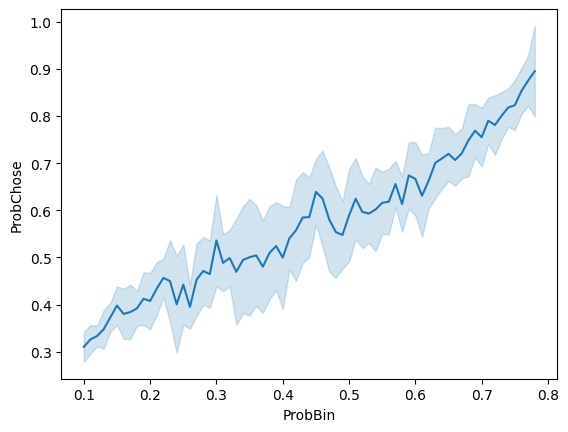

In [56]:
sns.lineplot(all_probs, x=f"ProbBin", y="ProbChose", errorbar="sd")

In [57]:
beh

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,PreferredBelief,PreferredBeliefProb,BeliefStateValueLabel,PreferredChosen,PrevResponse,PrevColor,PrevShape,PrevPattern,SQUAREProbBin,ProbBin
1,50,2,1,NaN,1881,Incorrect,2.0,11,SQUARE,SWIRL,...,SQUARE,0.097528,Low,False,Incorrect,YELLOW,CIRCLE,POLKADOT,0.0882,NaN
2,51,2,2,NaN,2206,Incorrect,3.0,11,SQUARE,SWIRL,...,ESCHER,0.110206,Low,False,Incorrect,CYAN,CIRCLE,SWIRL,0.0882,NaN
3,52,2,3,NaN,2005,Correct,0.0,11,SQUARE,SWIRL,...,SQUARE,0.124313,Low,True,Incorrect,MAGENTA,STAR,SWIRL,0.0882,NaN
4,53,2,4,NaN,1834,Correct,0.0,11,SQUARE,SWIRL,...,SQUARE,0.215905,Low,True,Correct,MAGENTA,SQUARE,SWIRL,0.2040,NaN
5,54,2,5,NaN,2059,Incorrect,2.0,11,SQUARE,SWIRL,...,SQUARE,0.311626,Low,False,Correct,CYAN,SQUARE,ESCHER,0.2820,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,876,26,13,NaN,2654,Correct,0.0,4,CYAN,GREEN,...,CYAN,0.716981,High CYAN,True,Correct,CYAN,SQUARE,ESCHER,0.0100,NaN
854,877,26,14,NaN,2557,Correct,0.0,4,CYAN,GREEN,...,CYAN,0.746958,High CYAN,True,Correct,CYAN,STAR,RIPPLE,0.0100,NaN
855,878,26,15,NaN,2696,Correct,0.0,4,CYAN,GREEN,...,CYAN,0.759059,High CYAN,True,Correct,CYAN,CIRCLE,SWIRL,0.0100,NaN
856,879,26,16,NaN,2567,Correct,0.0,4,CYAN,GREEN,...,CYAN,0.769641,High CYAN,True,Correct,CYAN,STAR,ESCHER,0.0100,NaN


In [ ]:
sns.lineplot(all_probs, x=f"ProbBin", y="ProbChose", errorbar="sd")